In [2]:
import time
import math
import json
import numpy as np
import pandas as pd
import seaborn as sb
!pip install pymap3d
import pymap3d as pm
import pymap3d.vincenty as pmv
import matplotlib.pyplot as plt
import glob as gl
import scipy.optimize
from tqdm.auto import tqdm
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.spatial import distance
from geopy.distance import geodesic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.4/55.4 kB 1.8 MB/s eta 0:00:00


In [3]:
# Constants
CLIGHT = 299_792_458   # speed of light (m/s)
RE_WGS84 = 6_378_137   # earth semimajor axis (WGS84) (m)
OMGE = 7.2921151467E-5  # earth angular velocity (IS-GPS) (rad/s)

In [4]:
# Satellite selection using carrier frequency error, elevation angle, and C/N0
def satellite_selection(df, column):
    """
    Args:
        df : DataFrame from device_gnss.csv
        column : Column name
    Returns:
        df: DataFrame with eliminated satellite signals
    """
    idx = df[column].notnull()
    idx &= df['CarrierErrorHz'] < 2.0e6  # carrier frequency error (Hz)
    idx &= df['SvElevationDegrees'] > 10.0  # elevation angle (deg)
    idx &= df['Cn0DbHz'] > 15.0  # C/N0 (dB-Hz)
    idx &= df['MultipathIndicator'] == 0 # Multipath flag

    return df[idx]

In [5]:
# Compute line-of-sight vector from user to satellite
def los_vector(xusr, xsat):
    """
    Args:
        xusr : user position in ECEF (m)
        xsat : satellite position in ECEF (m)
    Returns:
        u: unit line-of-sight vector in ECEF (m)
        rng: distance between user and satellite (m)
    """
    u = xsat - xusr
    rng = np.linalg.norm(u, axis=1).reshape(-1, 1)
    u /= rng
    
    return u, rng.reshape(-1)


# Compute Jacobian matrix
def jac_pr_residuals(x, xsat, pr, W):
    """
    Args:
        x : current position in ECEF (m)
        xsat : satellite position in ECEF (m)
        pr : pseudorange (m)
        W : weight matrix
    Returns:
        W*J : Jacobian matrix
    """
    u, _ = los_vector(x[:3], xsat)
    J = np.hstack([-u, np.ones([len(pr), 1])])  # J = [-ux -uy -uz 1]

    return W @ J


# Compute pseudorange residuals
def pr_residuals(x, xsat, pr, W):
    """
    Args:
        x : current position in ECEF (m)
        xsat : satellite position in ECEF (m)
        pr : pseudorange (m)
        W : weight matrix
    Returns:
        residuals*W : pseudorange residuals
    """
    u, rng = los_vector(x[:3], xsat)

    # Approximate correction of the earth rotation (Sagnac effect) often used in GNSS positioning
    rng += OMGE * (xsat[:, 0] * x[1] - xsat[:, 1] * x[0]) / CLIGHT

    # Add GPS L1 clock offset
    residuals = rng - (pr - x[3])

    return residuals @ W


# Compute Jacobian matrix
def jac_prr_residuals(v, vsat, prr, x, xsat, W):
    """
    Args:
        v : current velocity in ECEF (m/s)
        vsat : satellite velocity in ECEF (m/s)
        prr : pseudorange rate (m/s)
        x : current position in ECEF (m)
        xsat : satellite position in ECEF (m)
        W : weight matrix
    Returns:
        W*J : Jacobian matrix
    """
    u, _ = los_vector(x[:3], xsat)
    J = np.hstack([-u, np.ones([len(prr), 1])])

    return np.dot(W, J)


# Compute pseudorange rate residuals
def prr_residuals(v, vsat, prr, x, xsat, W):
    """
    Args:
        v : current velocity in ECEF (m/s)
        vsat : satellite velocity in ECEF (m/s)
        prr : pseudorange rate (m/s)
        x : current position in ECEF (m)
        xsat : satellite position in ECEF (m)
        W : weight matrix
    Returns:
        residuals*W : pseudorange rate residuals
    """
    u, rng = los_vector(x[:3], xsat)
    rate = np.sum((vsat-v[:3])*u, axis=1) \
          + OMGE / CLIGHT * (vsat[:, 1] * x[0] + xsat[:, 1] * v[0]
                           - vsat[:, 0] * x[1] - xsat[:, 0] * v[1])

    residuals = rate - (prr - v[3])

    return residuals @ W

In [6]:
# Carrier smoothing of pseudarange
def carrier_smoothing(gnss_df):
    """
    Args:
        df : DataFrame from device_gnss.csv
    Returns:
        df: DataFrame with carrier-smoothing pseudorange 'pr_smooth'
    """
    carr_th = 1.6 # carrier phase jump threshold [m] 2->1.5 (best)->1.0
    pr_th =  20.0 # pseudorange jump threshold [m] 20->15

    prsmooth = np.full_like(gnss_df['RawPseudorangeMeters'], np.nan)
    # Loop for each signal
    for (i, (svid_sigtype, df)) in enumerate((gnss_df.groupby(['Svid', 'SignalType']))):
        df = df.replace(
            {'AccumulatedDeltaRangeMeters': {0: np.nan}})  # 0 to NaN

        # Compare time difference between pseudorange/carrier with Doppler
        drng1 = df['AccumulatedDeltaRangeMeters'].diff() - df['PseudorangeRateMetersPerSecond']
        drng2 = df['RawPseudorangeMeters'].diff() - df['PseudorangeRateMetersPerSecond']

        # Check cycle-slip
        slip1 = (df['AccumulatedDeltaRangeState'].to_numpy() & 2**1) != 0  # reset flag
        slip2 = (df['AccumulatedDeltaRangeState'].to_numpy() & 2**2) != 0  # cycle-slip flag
        slip3 = np.fabs(drng1.to_numpy()) > carr_th # Carrier phase jump
        slip4 = np.fabs(drng2.to_numpy()) > pr_th # Pseudorange jump

        idx_slip = slip1 | slip2 | slip3 | slip4
        idx_slip[0] = True

        # groups with continuous carrier phase tracking
        df['group_slip'] = np.cumsum(idx_slip)

        # Psudorange - carrier phase
        df['dpc'] = df['RawPseudorangeMeters'] - df['AccumulatedDeltaRangeMeters']

        # Absolute distance bias of carrier phase
        meandpc = df.groupby('group_slip')['dpc'].mean()
        df = df.merge(meandpc, on='group_slip', suffixes=('', '_Mean'))

        # Index of original gnss_df
        idx = (gnss_df['Svid'] == svid_sigtype[0]) & (
            gnss_df['SignalType'] == svid_sigtype[1])

        # Carrier phase + bias
        prsmooth[idx] = df['AccumulatedDeltaRangeMeters'] + df['dpc_Mean']

    # If carrier smoothing is not possible, use original pseudorange
    idx_nan = np.isnan(prsmooth)
    prsmooth[idx_nan] = gnss_df['RawPseudorangeMeters'][idx_nan]
    gnss_df['pr_smooth'] = prsmooth

    return gnss_df

In [7]:
# Compute distance by Vincenty's formulae
def vincenty_distance(llh1, llh2):
    """
    Args:
        llh1 : [latitude,longitude] (deg)
        llh2 : [latitude,longitude] (deg)
    Returns:
        d : distance between llh1 and llh2 (m)
    """
    d, az = np.array(pmv.vdist(llh1[:, 0], llh1[:, 1], llh2[:, 0], llh2[:, 1]))

    return d


# Compute score
def calc_score(llh, llh_gt):
    """
    Args:
        llh : [latitude,longitude] (deg)
        llh_gt : [latitude,longitude] (deg)
    Returns:
        score : (m)
    """
    d = vincenty_distance(llh, llh_gt)
    score = np.mean([np.quantile(d, 0.50), np.quantile(d, 0.95)])

    return score

In [8]:
# GNSS single point positioning using pseudorange

def point_positioning(gnss_df):
    # Add nominal frequency to each signal
    # Note: GLONASS is an FDMA signal, so each satellite has a different frequency
    CarrierFrequencyHzRef = gnss_df.groupby(['Svid', 'SignalType'])[
        'CarrierFrequencyHz'].median()
    gnss_df = gnss_df.merge(CarrierFrequencyHzRef, how='left', on=[
                            'Svid', 'SignalType'], suffixes=('', 'Ref'))
    gnss_df['CarrierErrorHz'] = np.abs(
        (gnss_df['CarrierFrequencyHz'] - gnss_df['CarrierFrequencyHzRef']))

    # Carrier smoothing
    gnss_df = carrier_smoothing(gnss_df)

    # GNSS single point positioning
    utcTimeMillis = gnss_df['utcTimeMillis'].unique()
    nepoch = len(utcTimeMillis)
    x0 = np.zeros(4)  # [x,y,z,tGPSL1]
    v0 = np.zeros(4)  # [vx,vy,vz,dtGPSL1]
    x_wls = np.full([nepoch, 3], np.nan)  # For saving position
    v_wls = np.full([nepoch, 3], np.nan)  # For saving velocity

    # Loop for epochs
    for i, (t_utc, df) in enumerate(tqdm(gnss_df.groupby('utcTimeMillis'), total=nepoch)):
        # Valid satellite selection
        df_pr = satellite_selection(df, 'pr_smooth')
        df_prr = satellite_selection(df, 'PseudorangeRateMetersPerSecond')

        # Corrected pseudorange/pseudorange rate
        pr = (df_pr['pr_smooth'] + df_pr['SvClockBiasMeters'] - df_pr['IsrbMeters'] -
              df_pr['IonosphericDelayMeters'] - df_pr['TroposphericDelayMeters']).to_numpy()
        prr = (df_prr['PseudorangeRateMetersPerSecond'] +
               df_prr['SvClockDriftMetersPerSecond']).to_numpy()

        # Satellite position/velocity
        xsat_pr = df_pr[['SvPositionXEcefMeters', 'SvPositionYEcefMeters',
                         'SvPositionZEcefMeters']].to_numpy()
        xsat_prr = df_prr[['SvPositionXEcefMeters', 'SvPositionYEcefMeters',
                           'SvPositionZEcefMeters']].to_numpy()
        vsat = df_prr[['SvVelocityXEcefMetersPerSecond', 'SvVelocityYEcefMetersPerSecond',
                       'SvVelocityZEcefMetersPerSecond']].to_numpy()

        # Weight matrix for peseudorange/pseudorange rate
        Wx = np.diag(1 / df_pr['RawPseudorangeUncertaintyMeters'].to_numpy())
        Wv = np.diag(1 / df_prr['PseudorangeRateUncertaintyMetersPerSecond'].to_numpy())

        # Robust WLS requires accurate initial values for convergence,
        # so perform normal WLS for the first time
        if len(df_pr) >= 4:
            # Normal WLS
            if np.all(x0 == 0):
                opt = scipy.optimize.least_squares(
                    pr_residuals, x0, jac_pr_residuals, args=(xsat_pr, pr, Wx))
                x0 = opt.x 
            # Robust WLS for position estimation
            opt = scipy.optimize.least_squares(
                 pr_residuals, x0, jac_pr_residuals, args=(xsat_pr, pr, Wx), loss='soft_l1')
            if opt.status < 1 or opt.status == 2:
                 print(f'i = {i} position lsq status = {opt.status}')
            else:
                 x_wls[i, :] = opt.x[:3]
                 x0 = opt.x
                 
        # Velocity estimation
        if len(df_prr) >= 4:
            if np.all(v0 == 0): # Normal WLS
                opt = scipy.optimize.least_squares(
                    prr_residuals, v0, jac_prr_residuals, args=(vsat, prr, x0, xsat_prr, Wv))
                v0 = opt.x
            # Robust WLS for velocity estimation
            opt = scipy.optimize.least_squares(
                prr_residuals, v0, jac_prr_residuals, args=(vsat, prr, x0, xsat_prr, Wv), loss='soft_l1')
            if opt.status < 1:
                print(f'i = {i} velocity lsq status = {opt.status}')
            else:
                v_wls[i, :] = opt.x[:3]
                v0 = opt.x

    return utcTimeMillis, x_wls, v_wls

In [9]:
# Simple outlier detection and interpolation
def exclude_interpolate_outlier(x_wls, v_wls):
    # Up velocity threshold
    v_up_th = 2.0 # m/s

    # Coordinate conversion
    x_llh = np.array(pm.ecef2geodetic(x_wls[:, 0], x_wls[:, 1], x_wls[:, 2])).T
    v_enu = np.array(pm.ecef2enuv(
        v_wls[:, 0], v_wls[:, 1], v_wls[:, 2], x_llh[0, 0], x_llh[0, 1])).T

    # Up velocity jump detection
    # Cars don't jump suddenly!
    idx_v_out = np.abs(v_enu[:, 2]) > v_up_th
    v_wls[idx_v_out, :] = np.nan
    
    # Interpolate NaNs at beginning and end of array
    x_df = pd.DataFrame({'x': x_wls[:, 0], 'y': x_wls[:, 1], 'z': x_wls[:, 2]})
    x_df = x_df.interpolate(limit_area='outside', limit_direction='both')
    
    # Interpolate all NaN data
    v_df = pd.DataFrame({'x': v_wls[:, 0], 'y': v_wls[:, 1], 'z': v_wls[:, 2]})
    v_df = v_df.interpolate(limit_area='outside', limit_direction='both')
    v_df = v_df.interpolate('spline', order=3)

    return x_df.to_numpy(), v_df.to_numpy()

In [10]:
# Kalman filter
def Kalman_filter(zs, us, phone):
    # Parameters
    # I don't know why only XiaomiMi8 seems to be inaccurate ... 
    sigma_v = 0.6 if phone == 'XiaomiMi8' else 0.1 # velocity SD m/s
    sigma_x = 5.0  # position SD m
    sigma_mahalanobis = 30.0 # Mahalanobis distance for rejecting innovation
    
    n, dim_x = zs.shape
    F = np.eye(3)  # Transition matrix
    Q = sigma_v**2 * np.eye(3)  # Process noise

    H = np.eye(3)  # Measurement function
    R = sigma_x**2 * np.eye(3)  # Measurement noise

    # Initial state and covariance
    x = zs[0, :3].T  # State
    P = sigma_x**2 * np.eye(3)  # State covariance
    I = np.eye(dim_x)

    x_kf = np.zeros([n, dim_x])
    P_kf = np.zeros([n, dim_x, dim_x])

    # Kalman filtering
    for i, (u, z) in enumerate(zip(us, zs)):
        # First step
        if i == 0:
            x_kf[i] = x.T
            P_kf[i] = P
            continue

        # Prediction step
        x = F @ x + u.T
        P = (F @ P) @ F.T + Q

        # Check outliers for observation
        d = distance.mahalanobis(z, H @ x, np.linalg.pinv(P))

        # Update step
        if d < sigma_mahalanobis:
            y = z.T - H @ x
            S = (H @ P) @ H.T + R
            K = (P @ H.T) @ np.linalg.inv(S)
            x = x + K @ y
            P = (I - (K @ H)) @ P
        else:
            # If no observation update is available, increase covariance
            P += 10**2*Q

        x_kf[i] = x.T
        P_kf[i] = P

    return x_kf, P_kf


# Forward + backward Kalman filter and smoothing
def Kalman_smoothing(x_wls, v_wls, phone):
    n, dim_x = x_wls.shape

    # Forward
    v = np.vstack([np.zeros([1, 3]), (v_wls[:-1, :] + v_wls[1:, :])/2])
    x_f, P_f = Kalman_filter(x_wls, v, phone)

    # Backward
    v = -np.flipud(v_wls)
    v = np.vstack([np.zeros([1, 3]), (v[:-1, :] + v[1:, :])/2])
    x_b, P_b = Kalman_filter(np.flipud(x_wls), v, phone)

    # Smoothing
    x_fb = np.zeros_like(x_f)
    P_fb = np.zeros_like(P_f)
    for (f, b) in zip(range(n), range(n-1, -1, -1)):
        P_fi = np.linalg.inv(P_f[f])
        P_bi = np.linalg.inv(P_b[b])

        P_fb[f] = np.linalg.inv(P_fi + P_bi)
        x_fb[f] = P_fb[f] @ (P_fi @ x_f[f] + P_bi @ x_b[b])

    return x_fb, x_f, np.flipud(x_b)

  0%|          | 0/2070 [00:00<?, ?it/s]

Score Baseline   3.9088 [m]
Score Robust WLS 3.8837 [m]
Score KF         2.5120 [m]


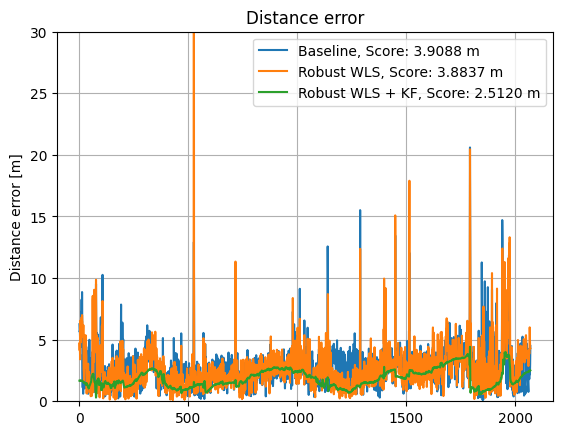

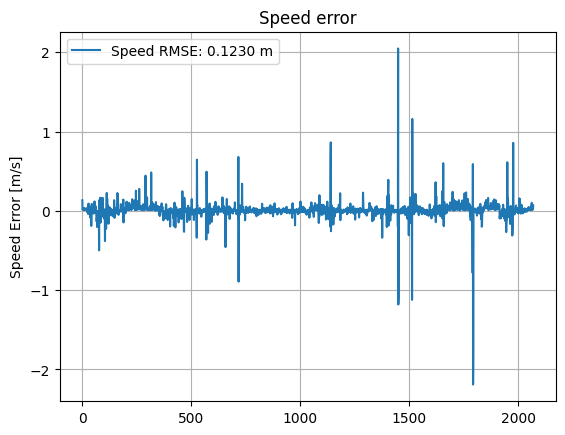

In [11]:
# Target course/phone
path = '/kaggle/input/smartphone-decimeter-2023/sdc2023/train/2023-09-07-22-48-us-ca-routebc2/pixel4xl'

drive, phone = path.split('/')[-2:]

# Read data
gnss_df = pd.read_csv(f'{path}/device_gnss.csv')  # GNSS data
gt_df = pd.read_csv(f'{path}/ground_truth.csv')  # ground truth

# Point positioning
utc, x_wls, v_wls = point_positioning(gnss_df)

# Exclude velocity outliers
x_wls, v_wls = exclude_interpolate_outlier(x_wls, v_wls)

# Kalman smoothing
x_kf, _, _ = Kalman_smoothing(x_wls, v_wls, phone)

# Convert to latitude and longitude
llh_wls = np.array(pm.ecef2geodetic(x_wls[:, 0], x_wls[:, 1], x_wls[:, 2])).T
llh_kf = np.array(pm.ecef2geodetic(x_kf[:, 0], x_kf[:, 1], x_kf[:, 2])).T

# Baseline
x_bl = gnss_df.groupby('TimeNanos')[
    ['WlsPositionXEcefMeters', 'WlsPositionYEcefMeters', 'WlsPositionZEcefMeters']].mean().to_numpy()
llh_bl = np.array(pm.ecef2geodetic(x_bl[:, 0], x_bl[:, 1], x_bl[:, 2])).T

# Ground truth
llh_gt = gt_df[['LatitudeDegrees', 'LongitudeDegrees']].to_numpy()

# Distance from ground truth
vd_bl = vincenty_distance(llh_bl, llh_gt)
vd_wls = vincenty_distance(llh_wls, llh_gt)
vd_kf = vincenty_distance(llh_kf, llh_gt)

# Score
score_bl = calc_score(llh_bl, llh_gt)
score_wls = calc_score(llh_wls, llh_gt)
score_kf = calc_score(llh_kf[:-1, :], llh_gt[:-1, :])

print(f'Score Baseline   {score_bl:.4f} [m]')
print(f'Score Robust WLS {score_wls:.4f} [m]')
print(f'Score KF         {score_kf:.4f} [m]')

# Plot distance error
plt.figure()
plt.title('Distance error')
plt.ylabel('Distance error [m]')
plt.plot(vd_bl, label=f'Baseline, Score: {score_bl:.4f} m')
plt.plot(vd_wls, label=f'Robust WLS, Score: {score_wls:.4f} m')
plt.plot(vd_kf, label=f'Robust WLS + KF, Score: {score_kf:.4f} m')
plt.legend()
plt.grid()
plt.ylim([0, 30])

# Compute velocity error
speed_wls = np.linalg.norm(v_wls[:, :3], axis=1)
speed_gt = gt_df['SpeedMps'].to_numpy()
speed_rmse = np.sqrt(np.sum((speed_wls-speed_gt)**2)/len(speed_gt))

# Plot velocity error
plt.figure()
plt.title('Speed error')
plt.ylabel('Speed Error [m/s]')
plt.plot(speed_wls - speed_gt, label=f'Speed RMSE: {speed_rmse:.4f} m')
plt.legend()
plt.grid()

In [13]:
path = '/kaggle/input/smartphone-decimeter-2023/sdc2023'
sample_df = pd.read_csv(f'{path}/sample_submission.csv')
test_dfs = []

# Loop for each trip
for i, dirname in enumerate(tqdm(sorted(gl.glob(f'{path}/test/*/*/')))):
    drive, phone = dirname.split('/')[-3:-1]
    tripID = f'{drive}/{phone}'
    print(tripID)

    # Read data
    gnss_df = pd.read_csv(f'{dirname}/device_gnss.csv')

    # Point positioning
    utc, x_wls, v_wls = point_positioning(gnss_df)

    # Exclude velocity outliers
    x_wls, v_wls = exclude_interpolate_outlier(x_wls, v_wls)

    # Kalman smoothing
    x_kf, _, _ = Kalman_smoothing(x_wls, v_wls, phone)

    # Convert to latitude and longitude
    llh_kf = np.array(pm.ecef2geodetic(x_kf[:, 0], x_kf[:, 1], x_kf[:, 2])).T

    # Interpolation for submission
    UnixTimeMillis = sample_df[sample_df['tripId'] == tripID]['UnixTimeMillis'].to_numpy()
    lat = InterpolatedUnivariateSpline(utc, llh_kf[:,0], ext=3)(UnixTimeMillis)
    lng = InterpolatedUnivariateSpline(utc, llh_kf[:,1], ext=3)(UnixTimeMillis)
    trip_df = pd.DataFrame({
        'tripId' : tripID,
        'UnixTimeMillis': UnixTimeMillis,
        'LatitudeDegrees': lat,
        'LongitudeDegrees': lng
        })

    test_dfs.append(trip_df)

  0%|          | 0/40 [00:00<?, ?it/s]

2020-12-11-19-30-us-ca-mtv-e/pixel4xl


  0%|          | 0/1190 [00:00<?, ?it/s]

2021-08-17-20-37-us-ca-mtv-g/pixel5


  0%|          | 0/1676 [00:00<?, ?it/s]

2021-08-31-20-37-us-ca-mtv-e/sm-g988b


/tmp/ipykernel_34/1628936598.py:12: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  gnss_df = pd.read_csv(f'{dirname}/device_gnss.csv')


  0%|          | 0/1141 [00:00<?, ?it/s]

2021-09-14-20-32-us-ca-mtv-k/pixel4


  0%|          | 0/1274 [00:00<?, ?it/s]

2021-09-20-19-03-us-ca-mtv-l/pixel4


  0%|          | 0/1797 [00:00<?, ?it/s]

2021-09-28-21-56-us-ca-mtv-a/mi8


/tmp/ipykernel_34/1628936598.py:12: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  gnss_df = pd.read_csv(f'{dirname}/device_gnss.csv')


  0%|          | 0/2479 [00:00<?, ?it/s]

i = 2358 position lsq status = 2
i = 2453 position lsq status = 2
2021-11-05-18-28-us-ca-mtv-m/pixel6pro


  0%|          | 0/1446 [00:00<?, ?it/s]

2021-11-30-20-59-us-ca-mtv-m/mi8


/tmp/ipykernel_34/1628936598.py:12: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  gnss_df = pd.read_csv(f'{dirname}/device_gnss.csv')


  0%|          | 0/1395 [00:00<?, ?it/s]

i = 15 position lsq status = 0
i = 101 position lsq status = 2
i = 118 position lsq status = 2
i = 120 position lsq status = 2
i = 121 position lsq status = 2
i = 123 position lsq status = 2
i = 124 position lsq status = 2
i = 125 position lsq status = 2
i = 126 position lsq status = 2
i = 127 position lsq status = 2
i = 128 position lsq status = 2
i = 129 position lsq status = 2
i = 130 position lsq status = 2
i = 131 position lsq status = 2
i = 133 position lsq status = 2
i = 135 position lsq status = 2
i = 137 position lsq status = 2
i = 139 position lsq status = 2
i = 140 position lsq status = 2
i = 141 position lsq status = 2
i = 142 position lsq status = 2
i = 143 position lsq status = 2
2022-02-08-22-04-us-ca-sjc-r/pixel5


  0%|          | 0/1665 [00:00<?, ?it/s]

2022-02-23-17-46-us-ca-lax-n/pixel5


  0%|          | 0/2407 [00:00<?, ?it/s]

2022-02-23-22-35-us-ca-lax-m/pixel5


  0%|          | 0/2805 [00:00<?, ?it/s]

2022-02-24-15-10-us-ca-lax-p/pixel5


  0%|          | 0/4515 [00:00<?, ?it/s]

i = 2752 position lsq status = 0
i = 2752 velocity lsq status = 0
2022-02-24-22-14-us-ca-lax-i/pixel5


  0%|          | 0/3582 [00:00<?, ?it/s]

2022-03-14-19-57-us-ca-mtv-pe1/xiaomimi8


/tmp/ipykernel_34/1628936598.py:12: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  gnss_df = pd.read_csv(f'{dirname}/device_gnss.csv')


  0%|          | 0/1679 [00:00<?, ?it/s]

2022-03-17-20-16-us-ca-sjc-q/sm-g988b


  0%|          | 0/1172 [00:00<?, ?it/s]

2022-03-22-18-44-us-ca-mtv-pe1/pixel5


  0%|          | 0/2112 [00:00<?, ?it/s]

2022-04-04-16-31-us-ca-lax-x/pixel5


  0%|          | 0/2171 [00:00<?, ?it/s]

2022-04-22-20-11-us-ca-ebf-y/pixel5


  0%|          | 0/1400 [00:00<?, ?it/s]

2022-04-25-21-04-us-ca-ebf-x/mi8


/tmp/ipykernel_34/1628936598.py:12: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  gnss_df = pd.read_csv(f'{dirname}/device_gnss.csv')


  0%|          | 0/1924 [00:00<?, ?it/s]

i = 10 position lsq status = 2
i = 700 position lsq status = 2
2022-04-25-22-36-us-ca-ebf-z/pixel5


  0%|          | 0/1587 [00:00<?, ?it/s]

2022-04-27-18-16-us-ca-ebf-zz/pixel5


  0%|          | 0/1315 [00:00<?, ?it/s]

2022-04-27-19-23-us-ca-ebf-xx/pixel5


  0%|          | 0/1382 [00:00<?, ?it/s]

2022-04-27-21-55-us-ca-ebf-ww/mi8


/tmp/ipykernel_34/1628936598.py:12: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  gnss_df = pd.read_csv(f'{dirname}/device_gnss.csv')


  0%|          | 0/1344 [00:00<?, ?it/s]

i = 324 position lsq status = 2
i = 331 position lsq status = 2
i = 393 position lsq status = 2
i = 508 position lsq status = 2
2022-05-12-20-19-us-ca-mtv-pe1/samsunga325g


  0%|          | 0/1435 [00:00<?, ?it/s]

2022-06-22-20-12-us-ca-lax-hh/samsunga325g


  0%|          | 0/1862 [00:00<?, ?it/s]

2022-06-28-20-56-us-ca-sjc-r/samsunga32


  0%|          | 0/1838 [00:00<?, ?it/s]

2022-07-12-18-37-us-ca-mtv-b/sm-a325f


  0%|          | 0/1782 [00:00<?, ?it/s]

2022-10-06-20-46-us-ca-sjc-r/sm-a205u


  0%|          | 0/1699 [00:00<?, ?it/s]

2023-04-27-19-25-us-ca-mtv-pe1/pixel5


  0%|          | 0/1357 [00:00<?, ?it/s]

2023-04-27-20-55-us-ca-sjc-q/pixel5


  0%|          | 0/1380 [00:00<?, ?it/s]

2023-05-02-19-24-us-ca-sjc-we1/pixel7pro


  0%|          | 0/2110 [00:00<?, ?it/s]

2023-05-02-20-33-us-ca-mtv-xe1/pixel7pro


/tmp/ipykernel_34/1628936598.py:12: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  gnss_df = pd.read_csv(f'{dirname}/device_gnss.csv')


  0%|          | 0/2145 [00:00<?, ?it/s]

2023-05-09-23-10-us-ca-sjc-r/sm-a505u


  0%|          | 0/2384 [00:00<?, ?it/s]

i = 1571 position lsq status = 2
i = 1573 position lsq status = 2
2023-05-23-21-06-us-ca-mtv-de1/pixel5


  0%|          | 0/1975 [00:00<?, ?it/s]

2023-05-23-22-16-us-ca-mtv-ie2/pixel6pro


  0%|          | 0/1020 [00:00<?, ?it/s]

2023-05-25-17-32-us-ca-pao-j/pixel6pro


/tmp/ipykernel_34/1628936598.py:12: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  gnss_df = pd.read_csv(f'{dirname}/device_gnss.csv')


  0%|          | 0/1292 [00:00<?, ?it/s]

2023-05-25-21-50-us-ca-sjc-ke2/sm-s908b


  0%|          | 0/1728 [00:00<?, ?it/s]

2023-05-26-21-23-us-ca-sjc-be2/pixel5


  0%|          | 0/1482 [00:00<?, ?it/s]

2023-06-06-22-43-us-ca-sjc-he2/pixel5


  0%|          | 0/1608 [00:00<?, ?it/s]

2023-06-15-18-49-us-ca-sjc-ce1/pixel7pro


/tmp/ipykernel_34/1628936598.py:12: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  gnss_df = pd.read_csv(f'{dirname}/device_gnss.csv')


  0%|          | 0/1495 [00:00<?, ?it/s]

i = 628 position lsq status = 2
i = 633 position lsq status = 2
i = 647 position lsq status = 2


In [14]:
# Write submission.csv
test_df = pd.concat(test_dfs)
test_df.to_csv('submission.csv', index=False)